# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('ggplot')

%matplotlib inline 

# Load Data

In [2]:
def load_data(machine_number):
    data = pd.read_csv('Data/machine_{}.csv'.format(machine_number))
    data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
    data = data.rename(columns = {'Unnamed: 0':'Time', '0': 'Feature 0','1': 'Feature 1', '2': 'Feature 2', '3': 'Feature 3'})
    return data 

machines = [load_data(i) for i in range(0, 20)]

# Exploratory Data Analysis

Are times between time points equal - can this be turned into an additional feature

Is the time period the same for each machine

What is the mean/ variance of each machine by Feature - might need to cleverly aggregate data for plotting

Is there any relation to days of the week

In [3]:
# look at data
machines[0].head(10)

,Time,Feature 0,Feature 1,Feature 2,Feature 3
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561
5,2019-01-02 16:00:48.016005335,29.646637,-3.522426,3.364964,-3.015832
6,2019-01-03 00:00:57.619206402,38.902674,1.916522,-10.849385,-17.702242
7,2019-01-03 08:01:07.222407469,33.052626,3.204629,25.474912,1.118645
8,2019-01-03 16:01:16.825608536,25.190551,-5.460431,22.956234,-3.472719
9,2019-01-04 00:01:26.428809603,29.554267,-3.325767,-5.842399,-25.124870


In [4]:
machines[0].describe()

,Feature 0,Feature 1,Feature 2,Feature 3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


In [5]:
# Check length of data
print(len(machines[0]))
for machine in machines:
    assert len(machine) == len(machines[0])

# Check if timestamp are different
for i in range(0, len(machines) -1):
    assert all(machines[i]['Time'] == machines[i+1]['Time'])
# Each measurement is taken 3 times a day at intervals of just over 8 hours

3000


## Visualize Data 

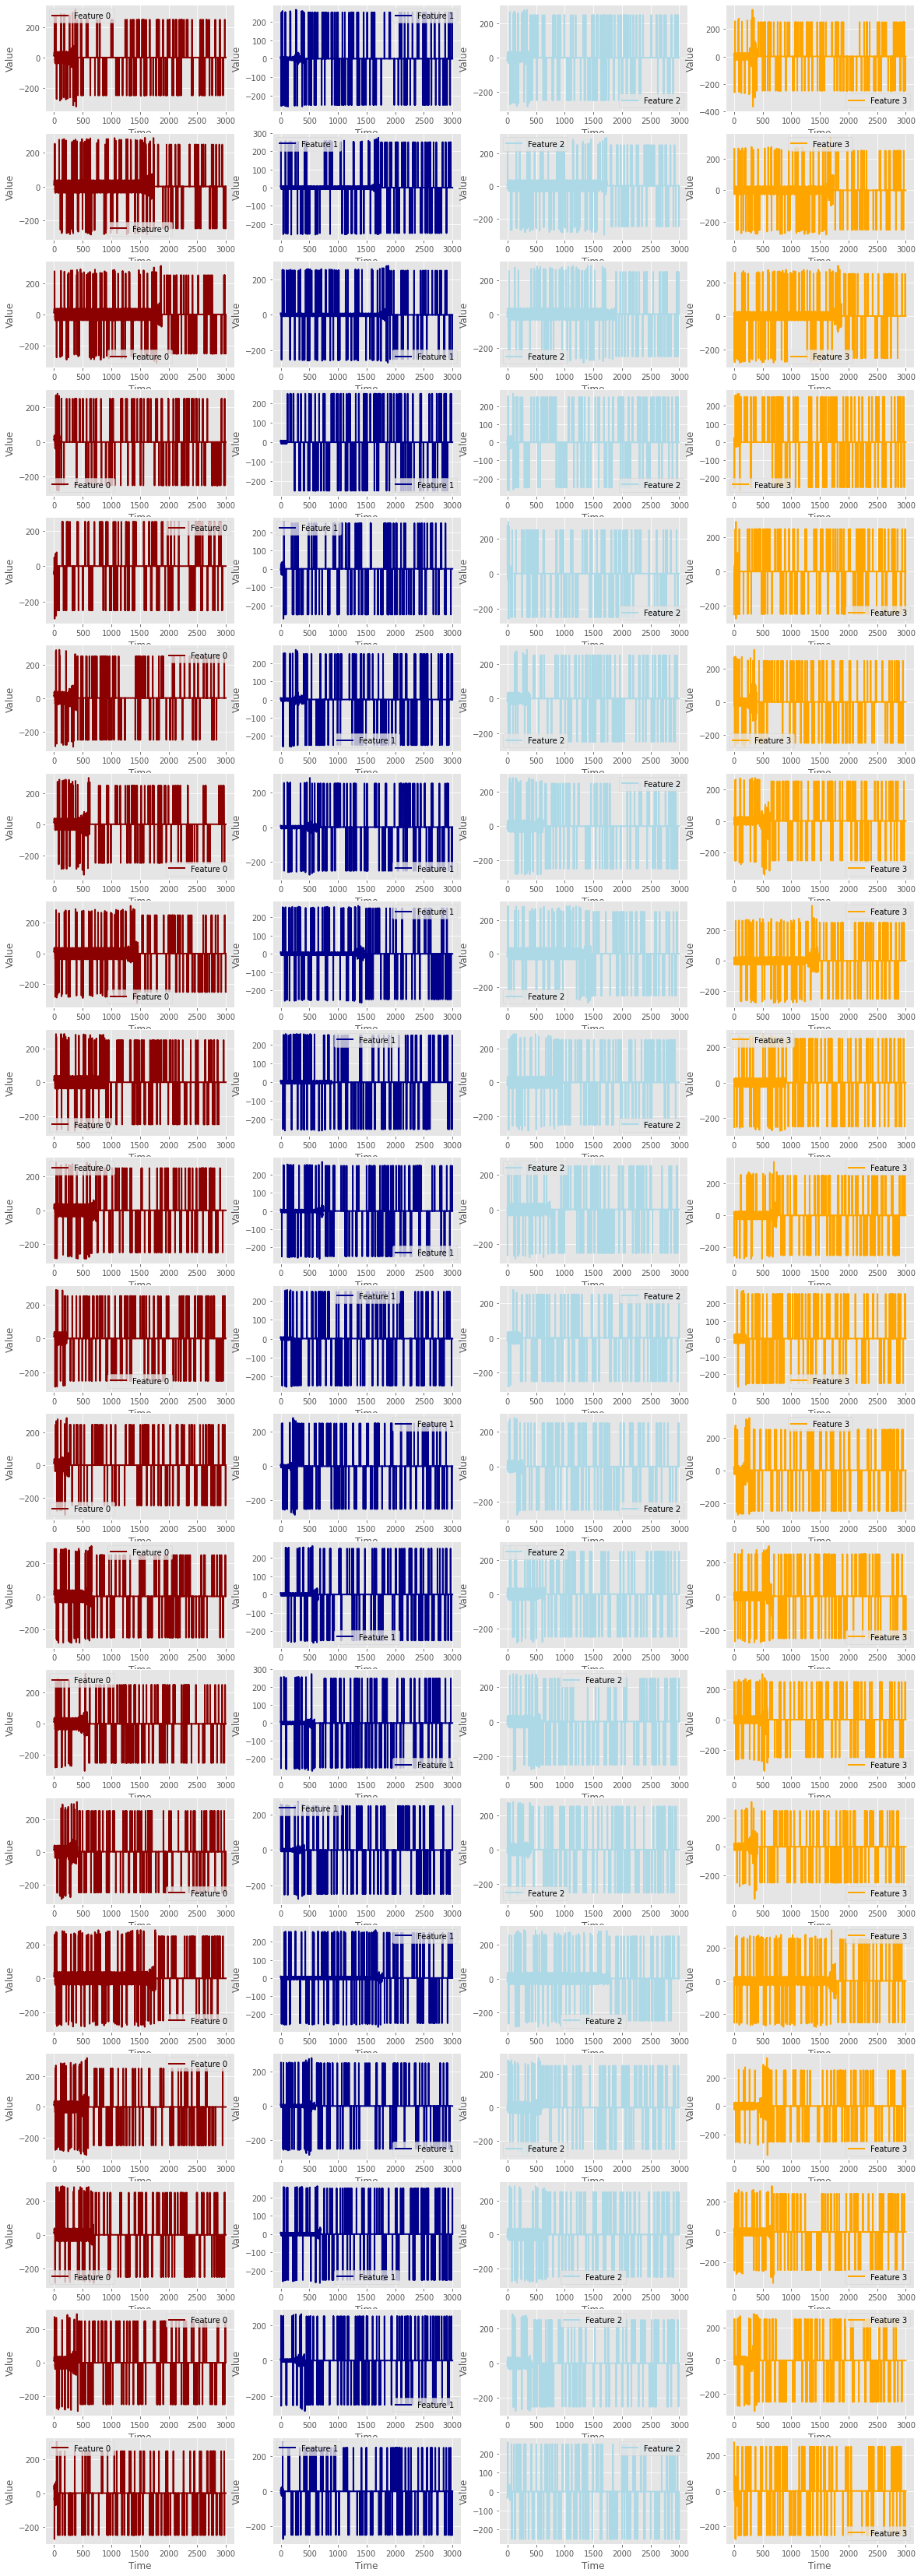

In [6]:
colors = {'0': 'darkred', '1': 'darkblue', '2': 'lightblue', '3': 'orange'}
def plot_feature(machine, feature, ax):
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    sns.lineplot(data = machine['Feature {}'.format(feature)], ax = ax, label = 'Feature {}'.format(feature), color = colors[str(feature)], lw = 2)

# Plot all machines and features
rows = len(machines)
cols = 4
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_time_series')

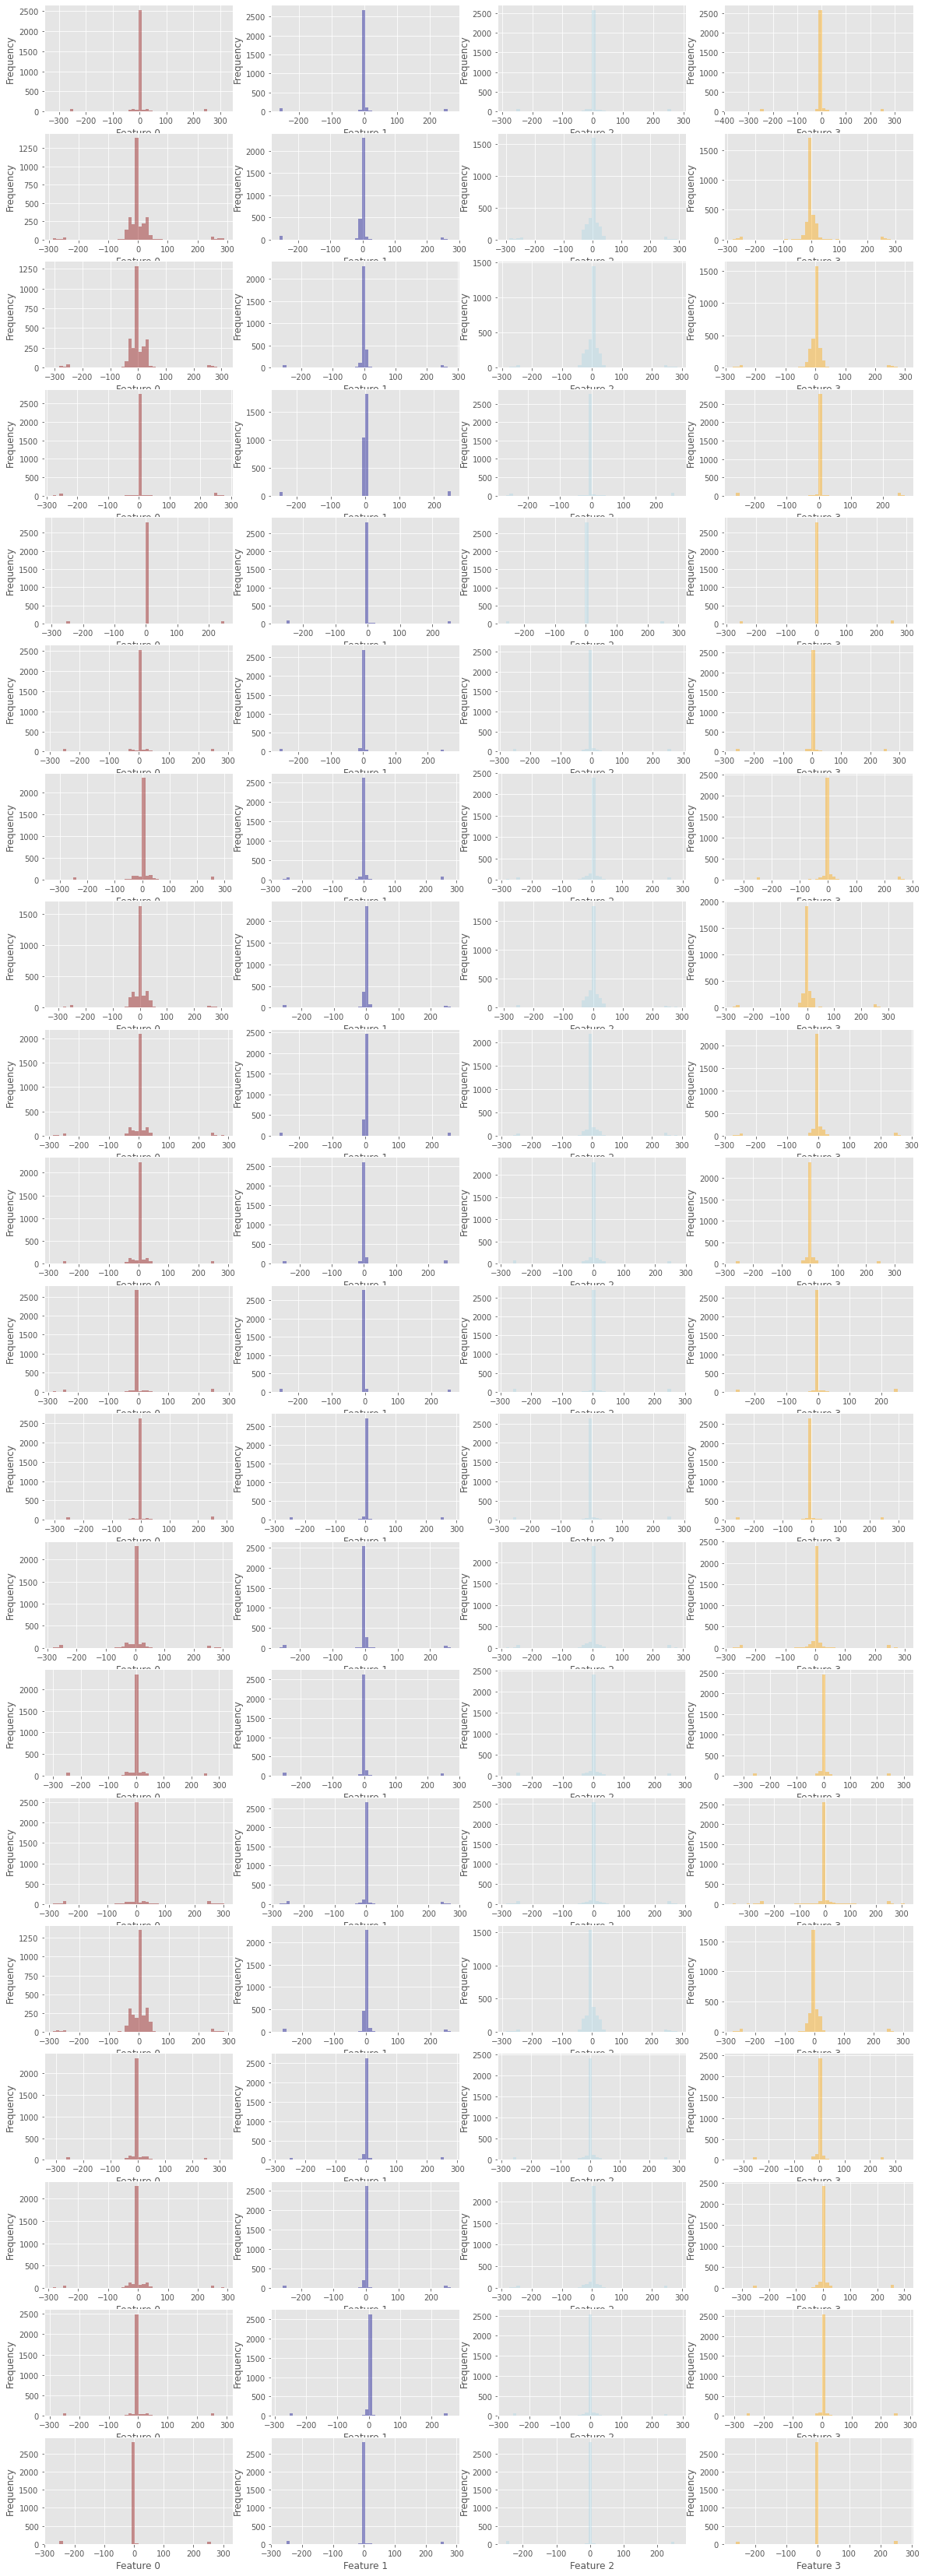

In [7]:
# Look at distributions of data 
def plot_feature_distributions(machine, feature, ax):
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    sns.distplot(machine['Feature {}'.format(feature)], kde = False,  ax = ax, label = 'Feature {}'.format(feature), color = colors[str(feature)])

fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature_distributions(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_distributions')


Look to be strong outliers at extreme positive and negative values which may be associated with communication errors.

These outliers also may have made potential relationships difficult to see on the above time series plots. 

Therefore we should evaluate what the data might look like after removing these outliers. 

## Outlier Removal

In [8]:
def remove_outliers(data):
    """Replace outliers with 0"""
    for i in range(0, 4):
        data.loc[(data['Feature {}'.format(i)] > 200)  | (data['Feature {}'.format(i)] < -200), 'Feature {}'.format(i)] = 0

for i in range(0, len(machines)):
    remove_outliers(machines[i])

## Replot with Outliers Removed

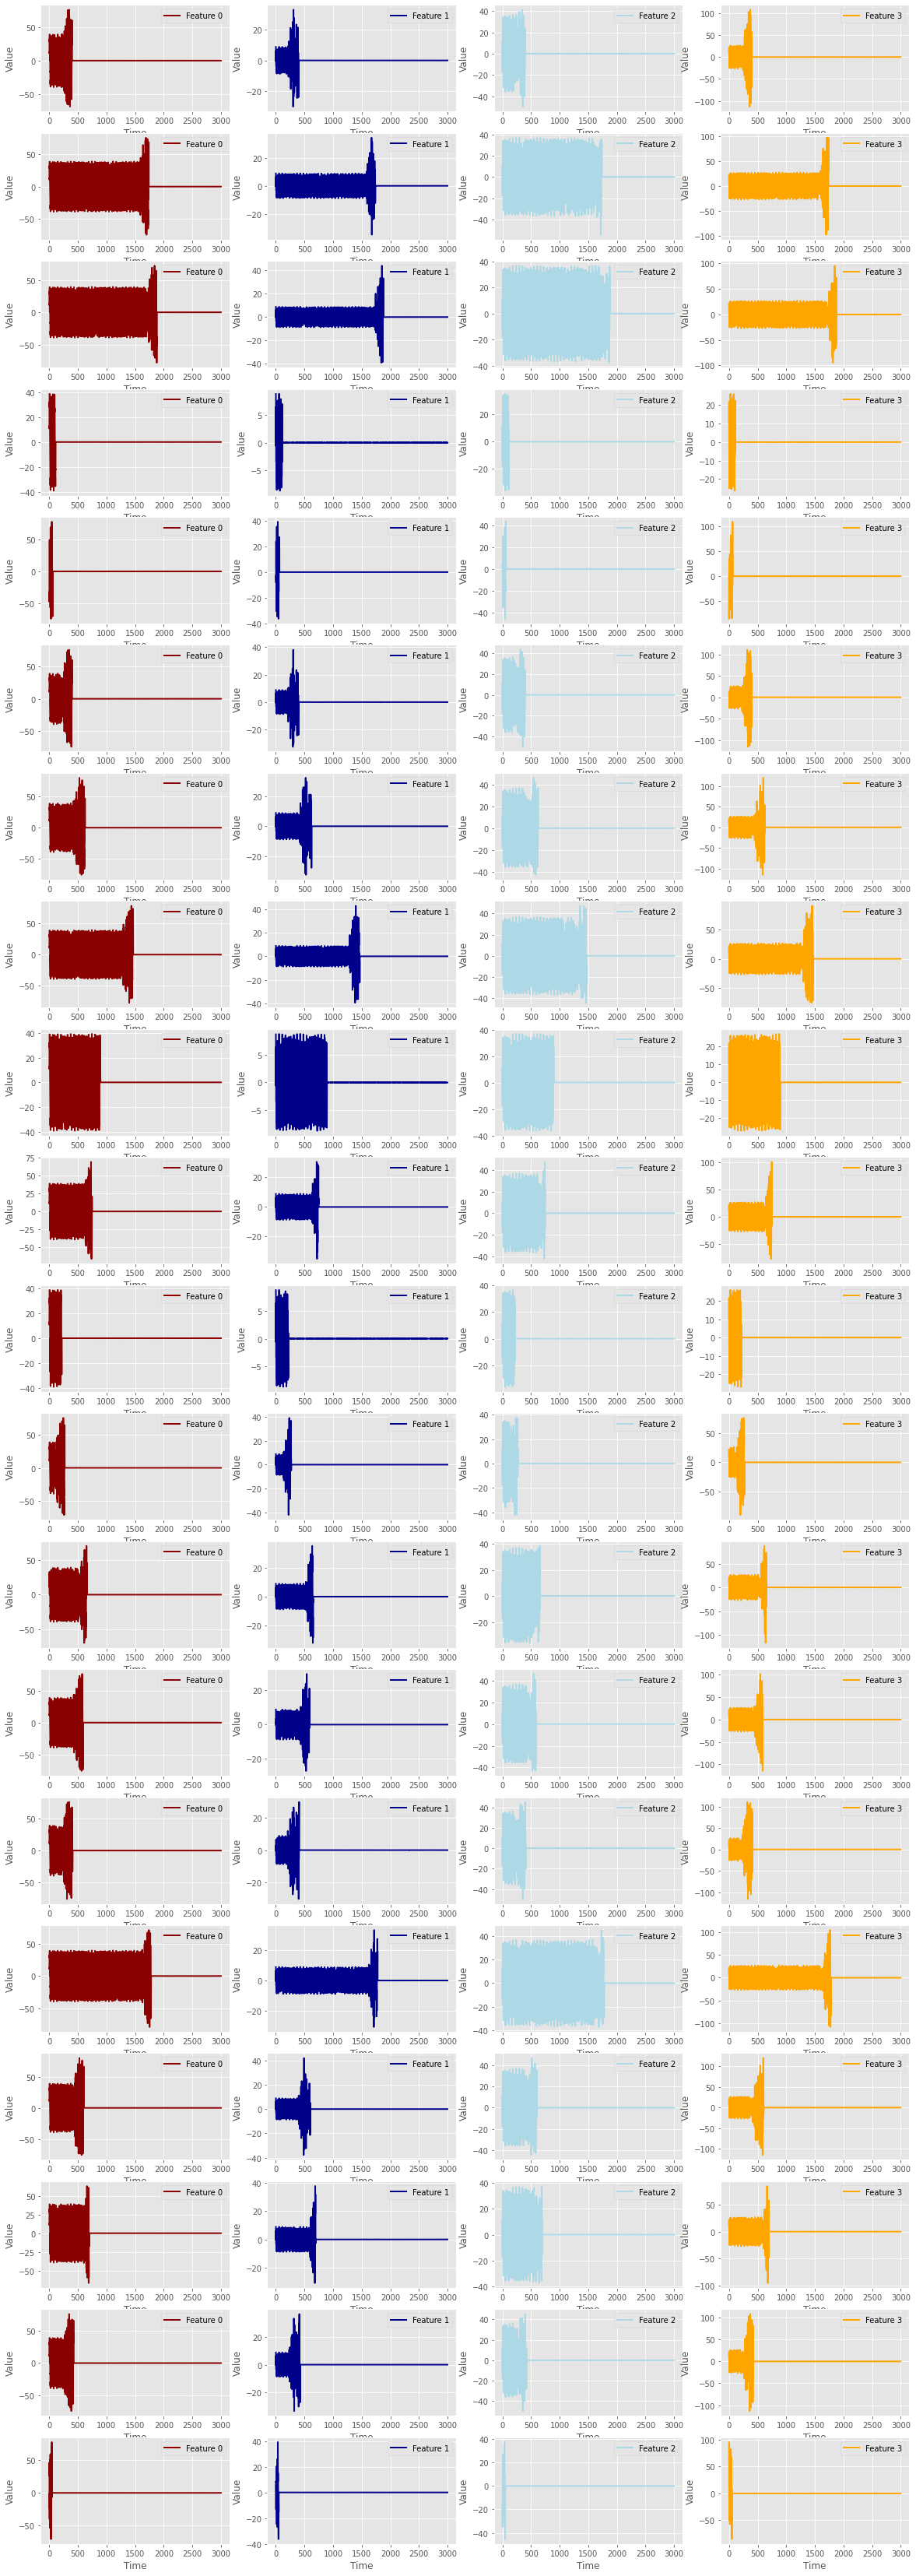

In [9]:
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_time_series_cleaned')

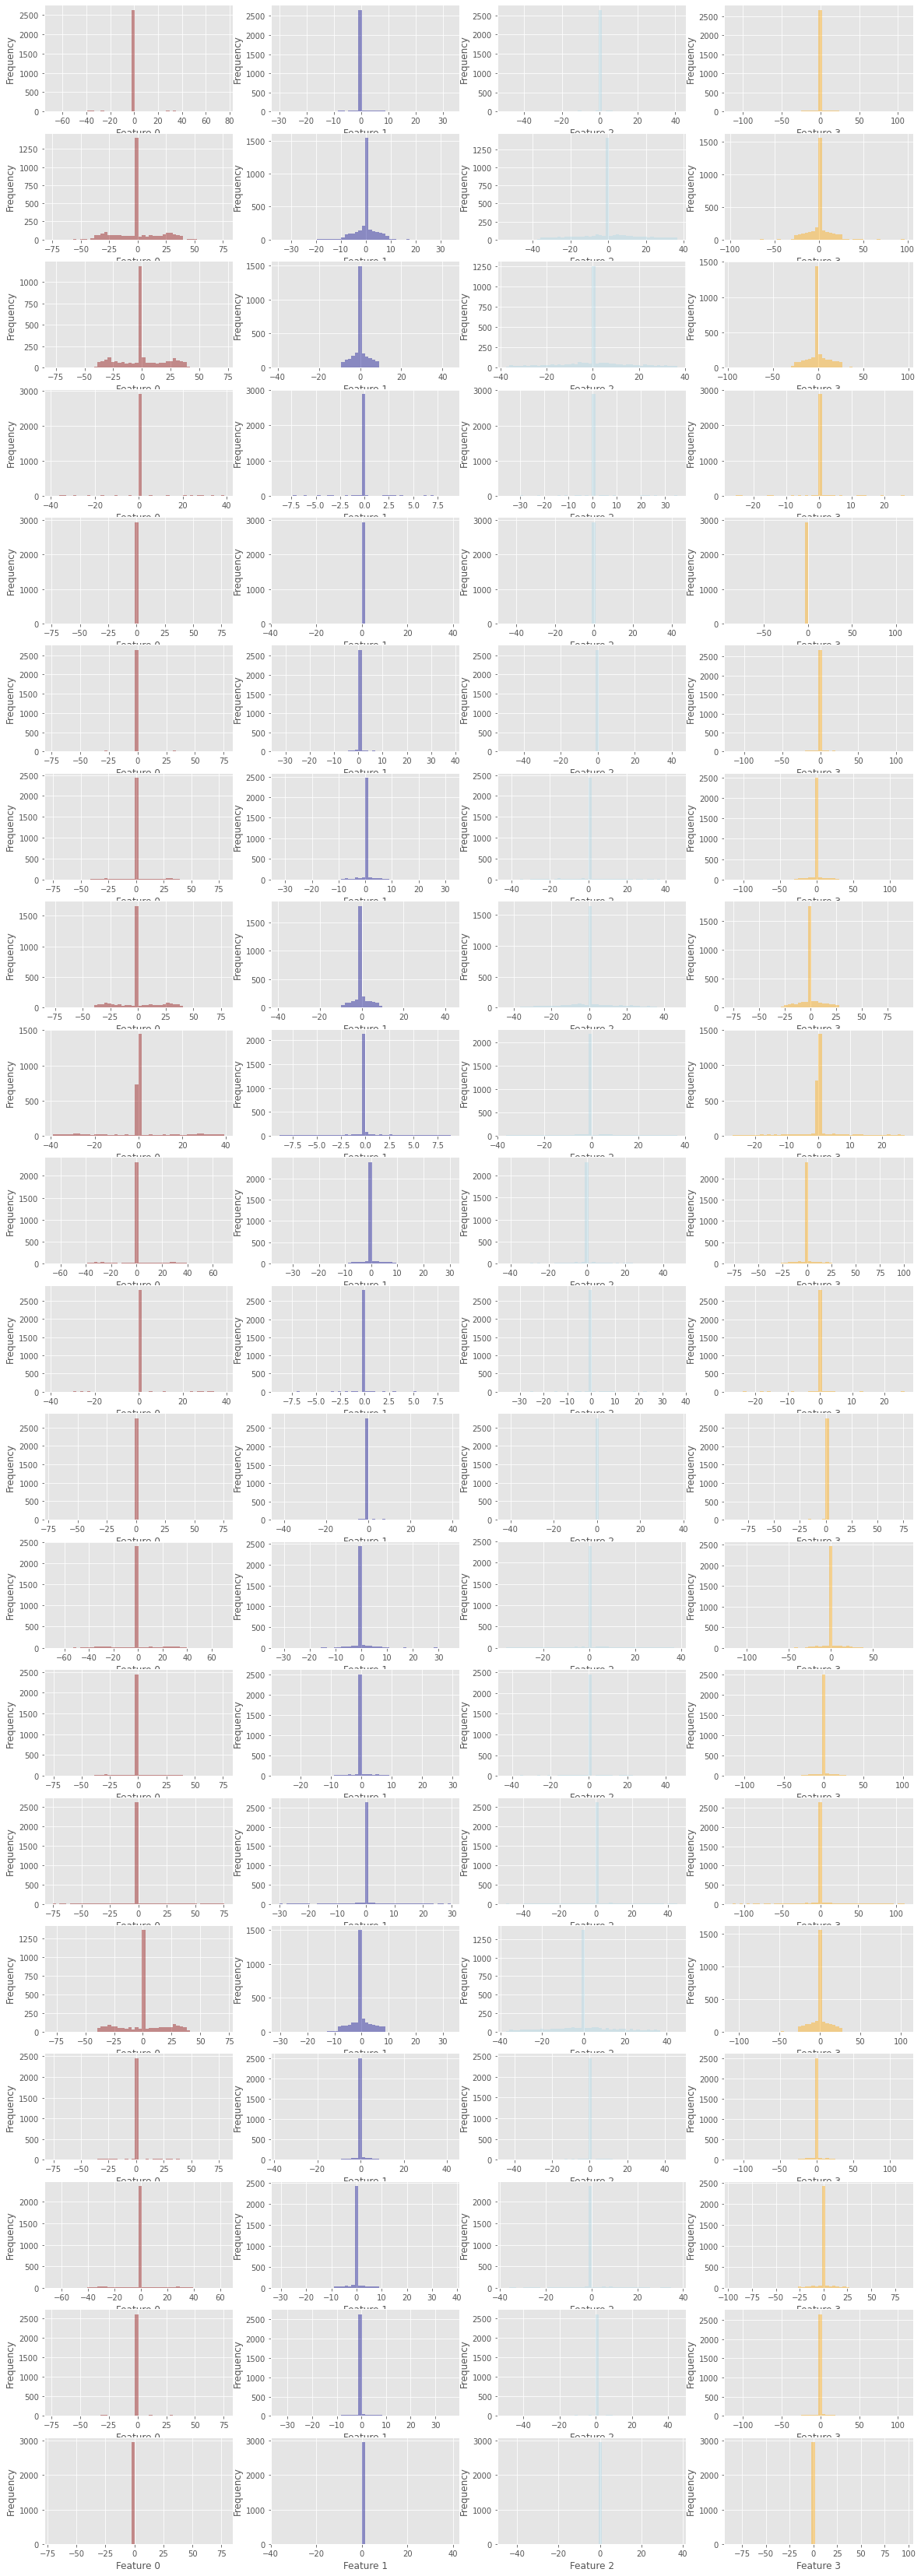

In [10]:
# Plot distributions
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature_distributions(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_distributions_cleaned')

## Feature Correlations

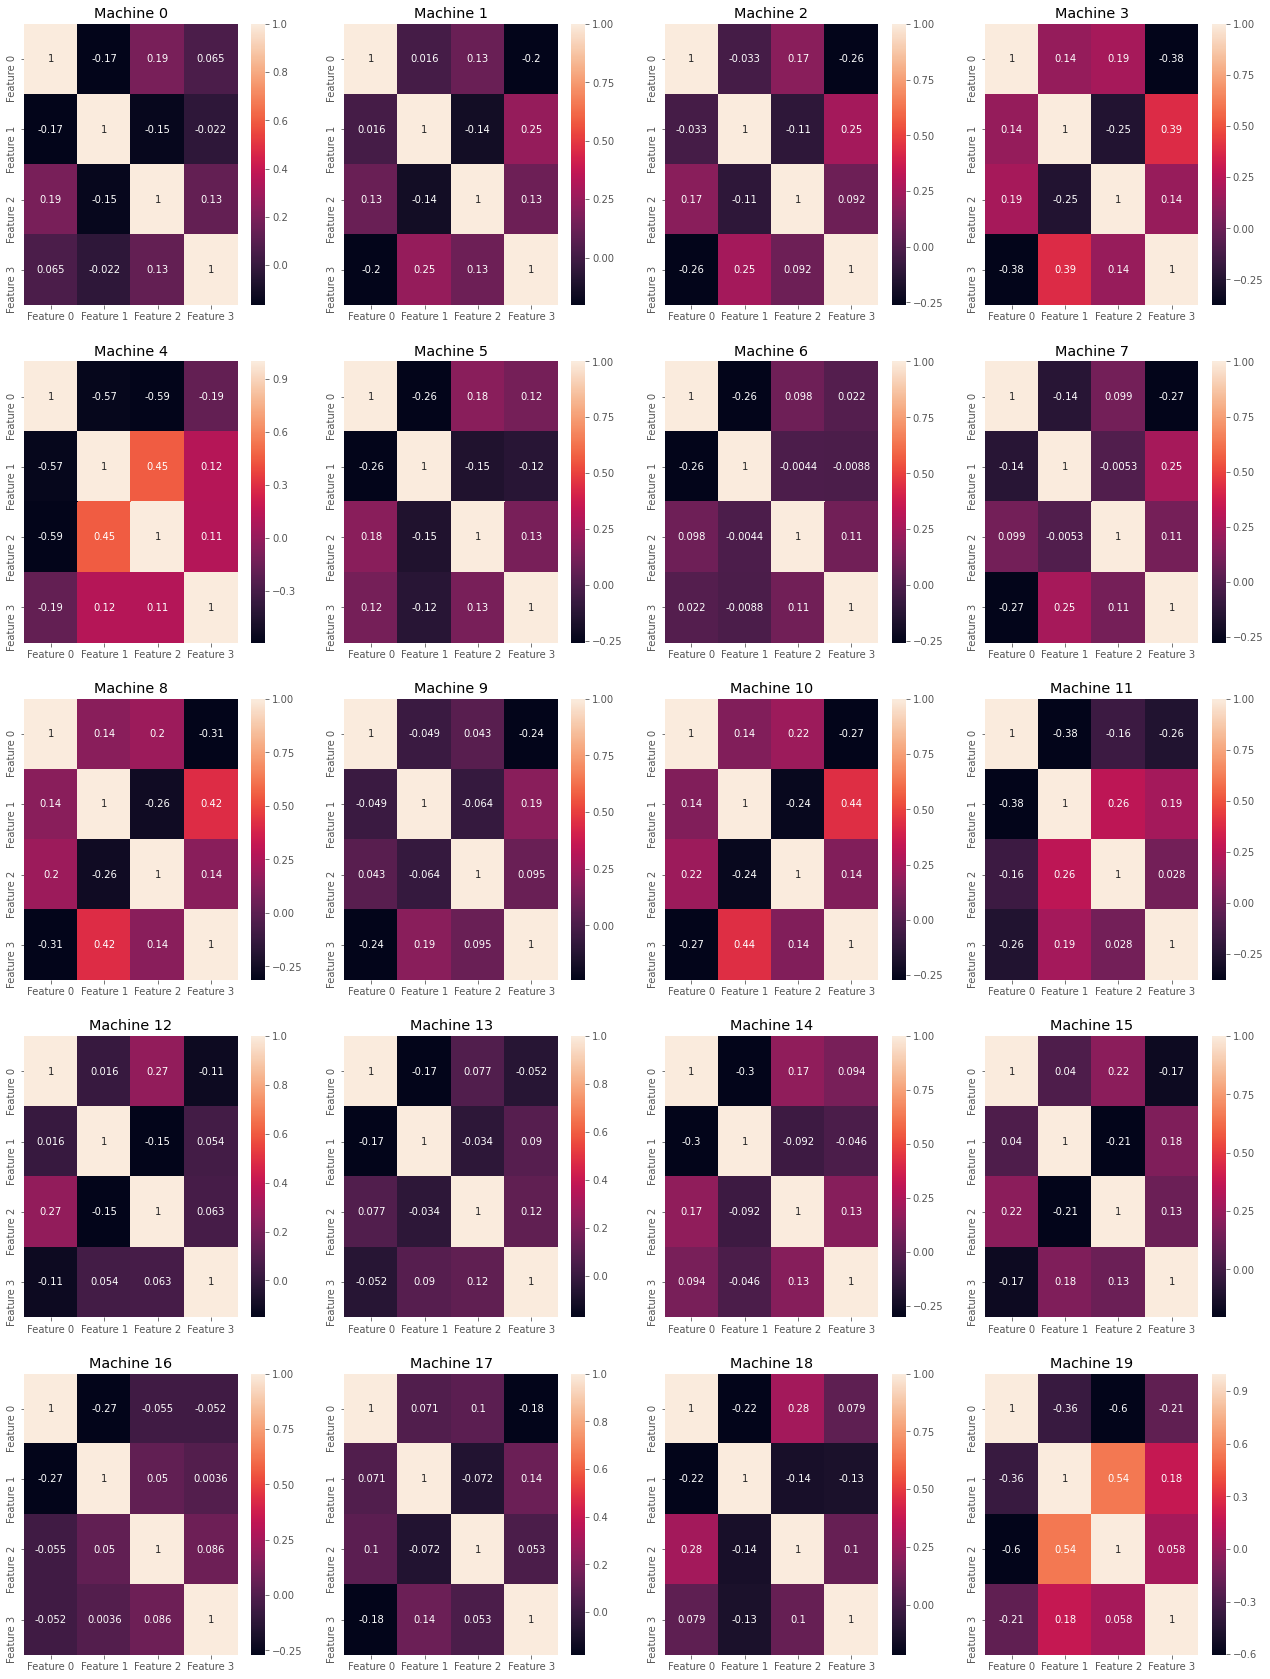

In [32]:
features = ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3']
def plot_correlation(machine, ax):
    """Plot heapmap of correlations between features between machines"""
    cor_matrix = machine[features].corr()
    sns.heatmap(cor_matrix, annot=True, ax = ax)

fig, ax = plt.subplots(5, 4, figsize = (22, 30))
for i, machine in enumerate(machines):
    ax[i//4][i%4].set_title('Machine {}'.format(i))
    plot_correlation(machine, ax[i//4][i%4])
fig.savefig('Figures/all_machines_correlations')

Most of the correlations between features for each machine are very small. 

## Summary

Each machine has a timeseries for each of four different features with 3000 observations collected at equal 8 hour intervals. The times of 

observations and intervals between them are the exact same which seems to indicate that including the intervals between observations as an 

additional feature would not be of much value. The data collection process seems to have been suspect to many noisy artifcacts. 

The histograms of feature values for each machines reveal a small number of extreme outliers at approximately plus or minus 250. Plotting the values of

each feature over time reveals that these outliers appear to be randomly distributed and may be obscuring the actual trends in the data. Therefore all 

outliers were removed and the time series and distribution plots were regenerated. In addtion, for each machine, the correlation between each 

pair of features in shown. Most of the larger correlations seems to result from machines where features take on values close to zero for much of the

time given. Therfore, correlations between features is not likely to significantly confound any subsequent analysis. Visual examination of the features 

plotted over time with the outliers removed seems to clearly reveal the 3 regimes that we are looking for. The normal regime is characterized by alternating 

positive and negative with relatively even values. Machines then enter a faulty regime where the magnitude of the signals appears to increase over time followed 

by the failure mode with the signals dropping close to zero. Different models can be used to determine when a machine has entered faulty mode. 





# Modeling 

## Detecting Failure Mode
The characteristics of the failure mode are very apparent upon inspecting the graphs of feature values
over time. We can set our failure time to be the point were a moving average of feature values drops below 
a certain threshold. We take the moving average of the absolute values of feature times because positive and negative values could
close to zero and the time series appears fairly symmetric. 

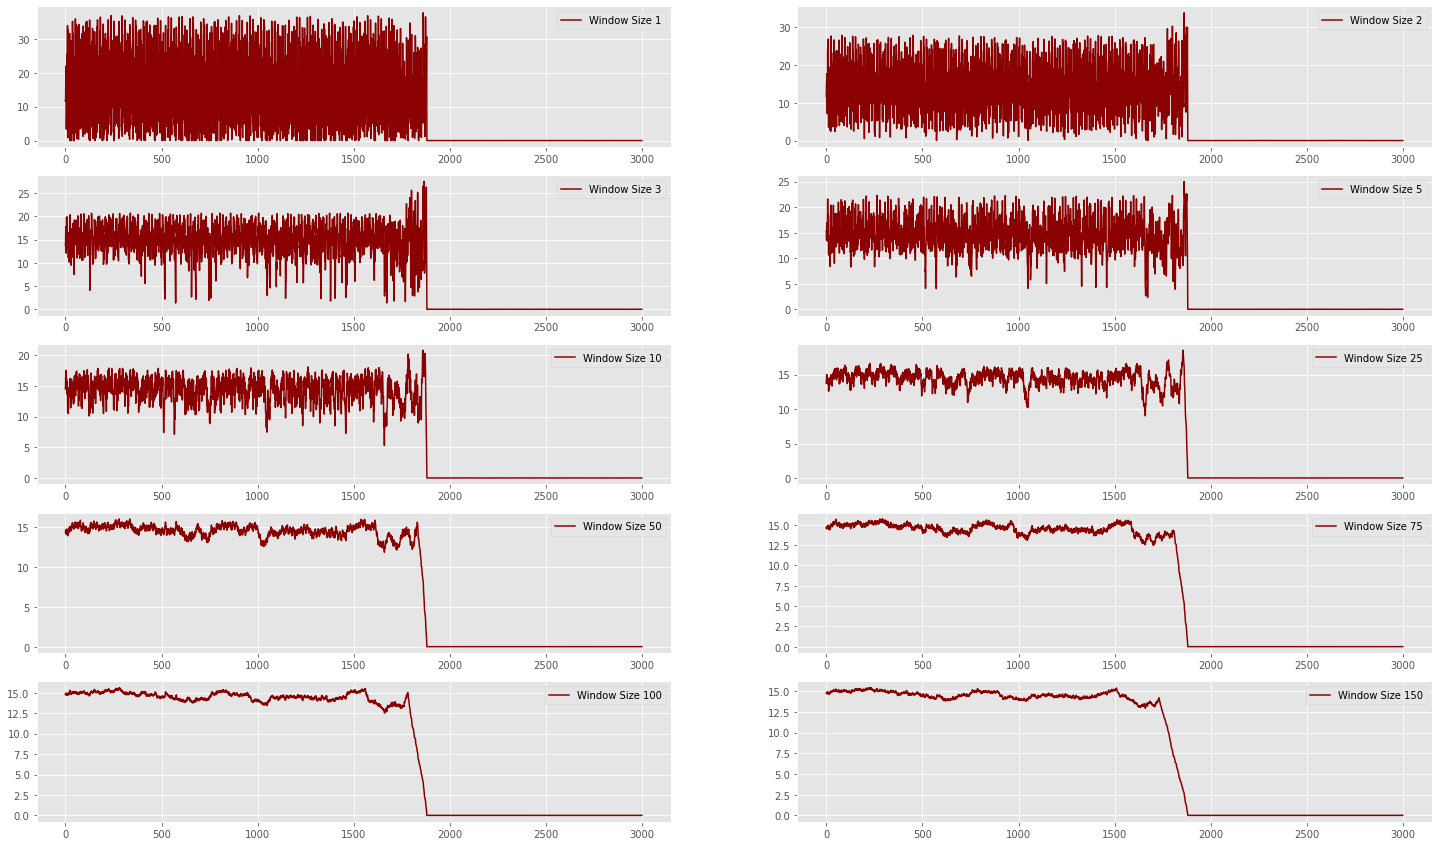

In [119]:
def moving_average(machine, feature, window):
    """Finds the moving average of a feature for a given window size"""
    data = machine[feature]
    n = len(data)
    data = np.array([np.absolute(data[i]) for i in range(0, n)])
    MA = np.array([np.mean(data[i: min(i + window, n-1)]) for i in range(0, n-1)])
    return MA

def plot_ma(machine, feature, window, ax):
    MA = moving_average(machine, feature, window)
    sns.lineplot(data = MA, ax = ax, label = 'Window Size {}'.format(window), color = 'darkred')


fig, ax = plt.subplots(5, 2, figsize = (25, 15))
windows = [1, 2, 3, 5, 10, 25, 50, 75, 100, 150]
for i, window in enumerate(windows):
    plot_ma(machines[2], 'Feature 2', window, ax[i//2][i%2])

We can see that using a window size of 1 which is equivalent to just looking at the absolute value of the signal at each time point will lead to problems because some values still approach 0. Taking moving averages with larger window sizes smoothes out the data so that we can see more of the general trend rather than outliers. In this case, it seems we can use a moving average wiht a window size of 3 to determine when a machine might enter failure mode. We can set failure mode to be when the moving avering with window size 3 drops below 0.25. Using the minimum window size of 5 should allow us to detect failure mode within as short a time as possible. We cannot use window size 2 or 3 because some moving average values replace 0. Window size 3 should allow us to label device failure within a few days. 

In [144]:
def detect_failure(machine, feature):
    MA = moving_average(machine, feature, 5)
    failure_point = np.argmax(MA< 0.25)
    return failure_point

failures = []
for machine in machines:
    entry = {}
    for feature in features:
        entry[feature] = detect_failure(machine, feature)
    failures.append(entry)

failures = pd.DataFrame(failures)
failures

,Feature 0,Feature 1,Feature 2,Feature 3
0,397,397,397,397
1,1738,1738,1738,1738
2,1880,1880,1880,1880
3,111,110,111,111
4,63,63,63,63
5,397,397,397,397
6,624,624,624,624
7,1466,1466,1466,1466
8,893,893,894,894
9,747,748,748,748


We can see that using this method yields the same result for every feature and therefore gives us a good label for when failure occurs. Plotting the failure times can give us confidence as to their accuracy.

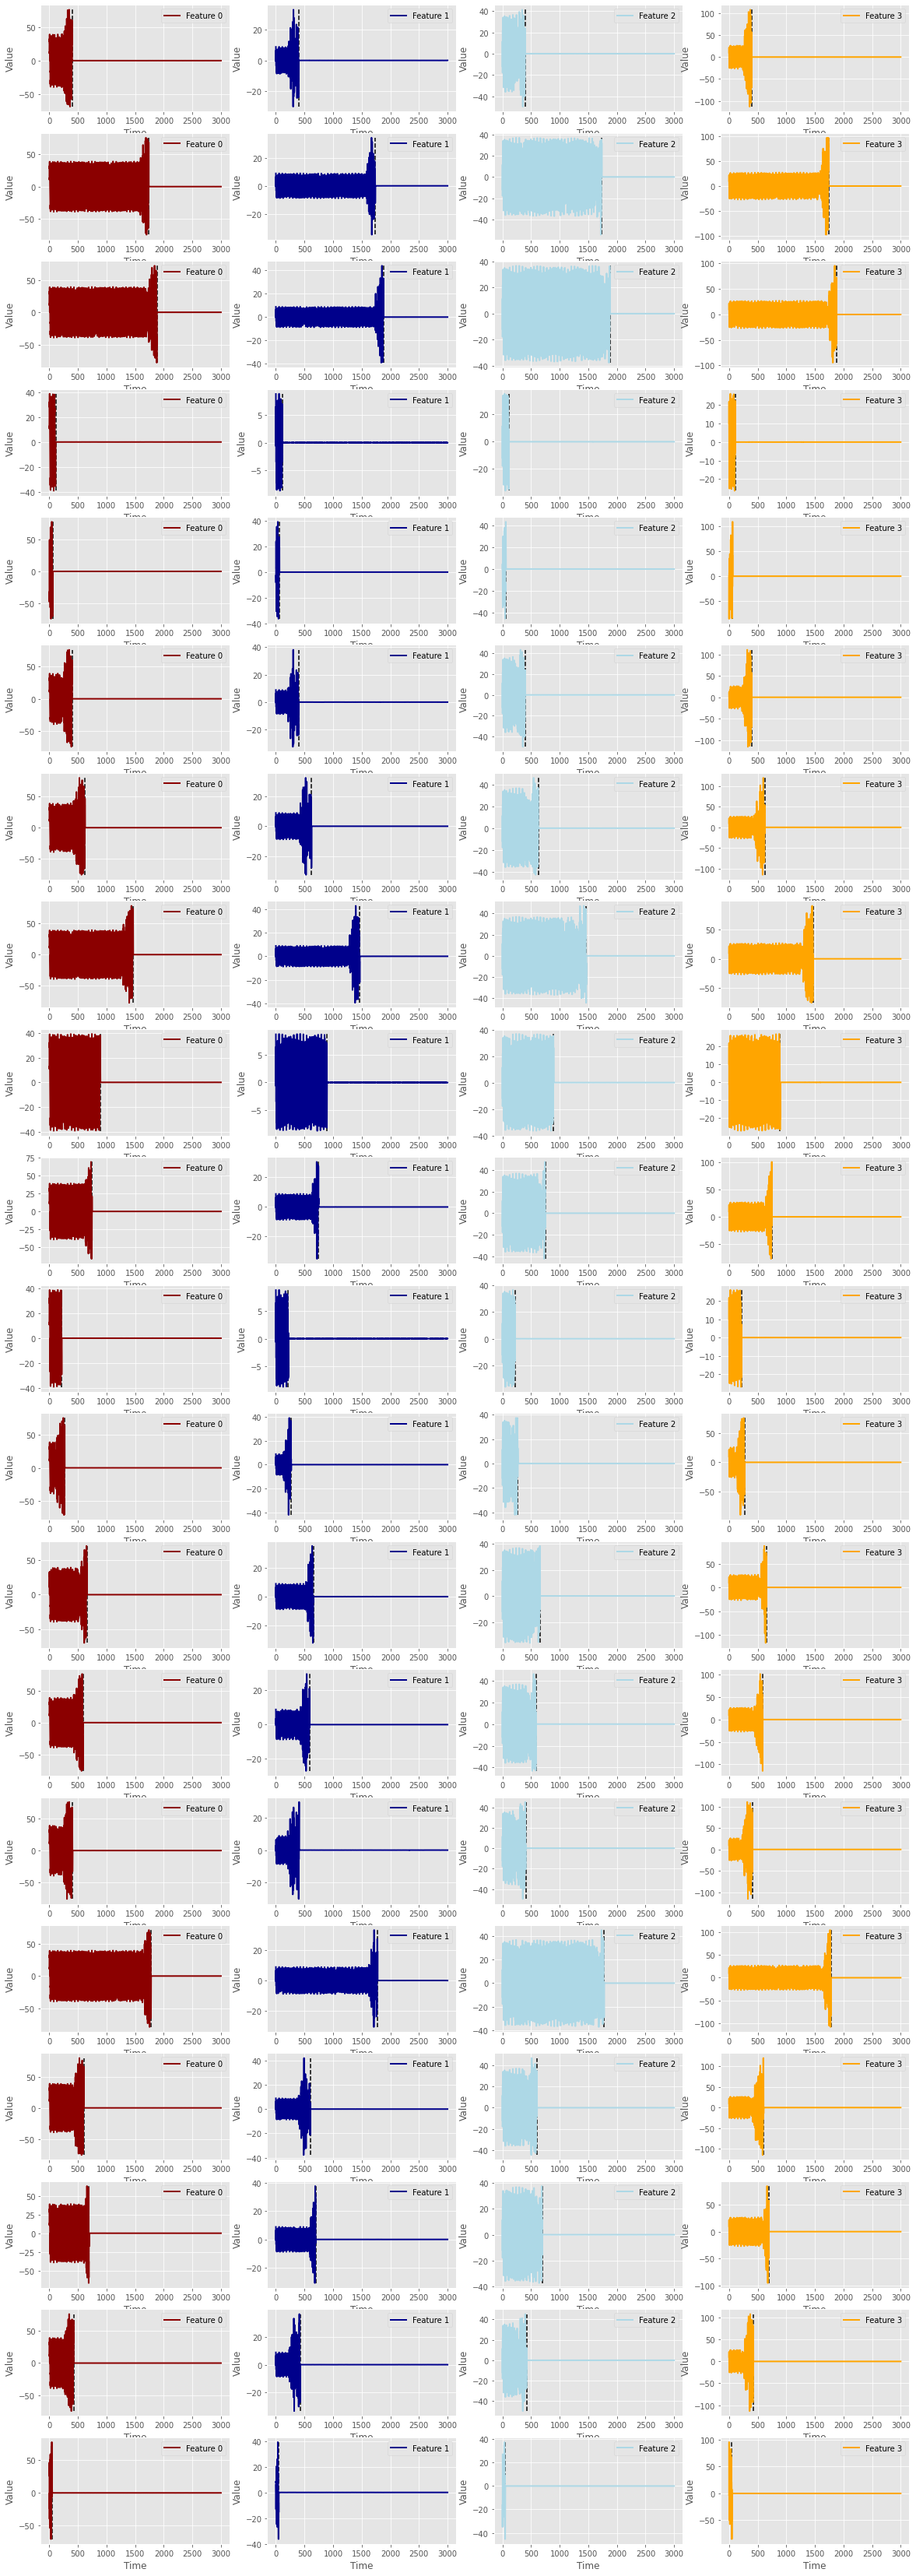

In [139]:
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature(machines[i], j, ax[i, j])
        ax[i,j].vlines(x = detect_failure(machines[i], features[j]), ymin = np.min(machines[i][features[j]]), ymax = np.max(machines[i][features[j]]), linestyles = 'dashed', label = 'Failure Time')
fig.savefig('Figures/all_machines_time_series_failure_times')

## Labeling Faulty Mode 

## Survival Analysis

## Detecting Faulty Mode

# Conclusions